# Sentence Classification with Convolutional Neural Network

Keras 2.0 implementation based on:
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf
* https://github.com/yoonkim/CNN_sentence  
* http://www.people.fas.harvard.edu/~yoonkim/data/sent-cnn.pdf (The original paper)



In [0]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer

## Set up data source and model hyperparameters

In [0]:
positive_data_file = "data/rt-polarity.pos"
negative_data_file = "data/rt-polarity.neg"
# Percentage of the training data to use for validation
dev_sample_percentage = 0.1
# Dimensionality of character embedding (default: 128)
embedding_dim = 128
# Filter sizes (default: [3, 4, 5])
filter_sizes = [3, 4, 5]
# Number of filters per filter size (default: 128)
num_filters = 128
# L2 regularization lambda (default: 0.0) (unused)
l2_reg_lambda = 0.0
# Dropout keep probability (default: 0.5)
dropout_keep_prob = 0.5
# Batch Size (default: 64)
batch_size = 64
# Number of training epochs (default: 200)
num_epochs = 200

## Load the data

In [0]:
# Load data from files
positive_examples = list(open(positive_data_file, "r", encoding='utf-8').readlines())
negative_examples = list(open(negative_data_file, "r", encoding='utf-8').readlines())
# Concatenate
x_text = positive_examples + negative_examples
# Generate labels
positive_labels = [[0, 1] for _ in positive_examples]
negative_labels = [[1, 0] for _ in negative_examples]
y = np.concatenate([positive_labels, negative_labels], 0)

## Prepare the data

Tokenize text into number sequences.

Pad sequences to the same length (of the longest sequence).

Shuffle the dataset.

In [0]:
# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
# Tokenizer default filtering seems to be identical to original clean_str
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_text)
x = np.array(tokenizer.texts_to_sequences(x_text))
# Pad examples to the same length
x = keras.preprocessing.sequence.pad_sequences(x,
                                               value=0,
                                               padding='post',
                                               maxlen=max_document_length)

In [0]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_train = x[shuffle_indices]
y_train = y[shuffle_indices]

del x, y

## Build the model

In [0]:
# Build the model
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_size = embedding_dim

print("Sequence Length: {}".format(sequence_length))
print("Number of Classes: {}".format(num_classes))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_size))

inputs = keras.layers.Input(shape=(sequence_length,))
x = keras.layers.Embedding(vocab_size, embedding_size, input_length=sequence_length,
                          embeddings_initializer='random_uniform')(inputs)
x = keras.layers.Reshape((sequence_length, embedding_size, 1))(x)

filter_layers = []

for s in filter_sizes:
  f = keras.layers.Conv2D(
      num_filters, kernel_size=(s, embedding_size), strides=(1, 1),
      padding='valid', data_format='channels_last', activation='relu',
      use_bias=True, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01),
      bias_initializer=keras.initializers.Constant(value=0.1))(x)
  f = keras.layers.MaxPooling2D(pool_size=(sequence_length - s + 1, 1), strides=(1, 1), padding='valid', data_format='channels_last')(f)
  filter_layers.append(f)

# Combine all the pooled features
x = keras.layers.concatenate(filter_layers, axis=1)
x = keras.layers.Reshape((num_filters * len(filter_sizes), ))(x)

# Add dropout
x = keras.layers.Dropout(dropout_keep_prob)(x)

# Final (unnormalized) scores and predictions
predictions = keras.layers.Dense(num_classes, use_bias=True, 
                                 bias_initializer=keras.initializers.Constant(value=0.1),
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=None),
                                 kernel_regularizer=keras.regularizers.l2(l2_reg_lambda), 
                                 bias_regularizer=keras.regularizers.l2(l2_reg_lambda),
                                 activation='softmax')(x)
  
model = keras.Model(inputs=inputs, outputs=predictions)
model.summary()

Sequence Length: 61
Number of Classes: 2
Vocabulary Size: 19484
Embedding Size: 128
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 61)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 61, 128)      2493952     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 61, 128, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 1, 128)   49280       reshape_1[0][0]                  
_________________________

## Visualize the model

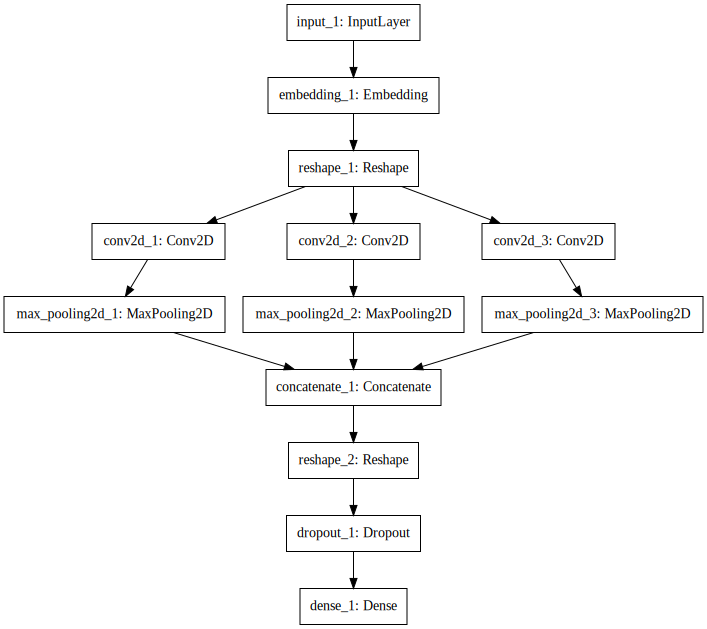

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Prepare the training

Specify loss function and optimizer.

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train the model

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=dev_sample_percentage,
                    verbose=1)

Train on 9595 samples, validate on 1067 samples
Epoch 1/200
9595/9595 [==============================] - 2s 202us/step - loss: 0.6243 - acc: 0.6286 - val_loss: 0.5260 - val_acc: 0.7320
Epoch 2/200
9595/9595 [==============================] - 1s 134us/step - loss: 0.3519 - acc: 0.8470 - val_loss: 0.5053 - val_acc: 0.7638
Epoch 3/200
9595/9595 [==============================] - 1s 134us/step - loss: 0.1463 - acc: 0.9497 - val_loss: 0.6359 - val_acc: 0.7591
Epoch 4/200
9595/9595 [==============================] - 1s 133us/step - loss: 0.0534 - acc: 0.9833 - val_loss: 0.8648 - val_acc: 0.7301
Epoch 5/200
9595/9595 [==============================] - 1s 135us/step - loss: 0.0206 - acc: 0.9948 - val_loss: 0.9689 - val_acc: 0.7451
Epoch 6/200
9595/9595 [==============================] - 1s 135us/step - loss: 0.0092 - acc: 0.9981 - val_loss: 1.1073 - val_acc: 0.7357
Epoch 7/200
9595/9595 [==============================] - 1s 134us/step - loss: 0.0039 - acc: 0.9995 - val_loss: 1.1911 - val_acc: 

## Plot training history

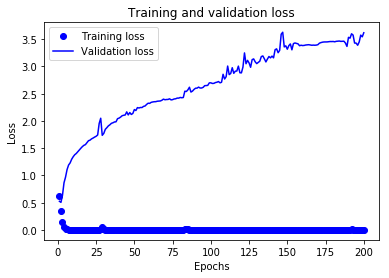

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

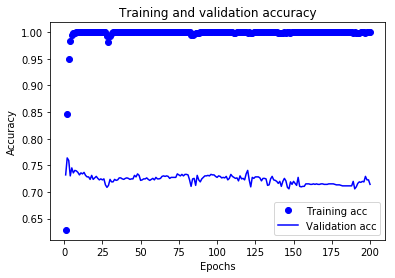

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluate the model

Test the model on data that the model wasn't trained on.

In [0]:
x_raw = np.array(["a masterpiece four years in the making", "everything is off."])
y_test = np.array([[1, 0], [0, 1]])

x_prep = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(x_raw),
                                               value=0,
                                               padding='post',
                                               maxlen=max_document_length)
  
results = model.evaluate(x_prep, y_test)
print(model.predict(x_prep))

2/2 [==============================] - 0s 1ms/step
[[0.0000000e+00 1.0000000e+00]
 [9.9995232e-01 4.7675734e-05]]
